<a href="https://colab.research.google.com/github/kanru-wang/Udemy_GAN_and_Diffusion_models/blob/main/text_to_image_stable_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text to Image Stable Diffusion

https://github.com/huggingface/diffusion-models-class

### Why don't we just denoise in a single large step?

For low noise, denoising is easy. For high noise, denoising is hard; the results tend to be blurry.

### Class-Conditioned UNet

If the image shape is (bs, 3, 28, 28), and class embedding size is 4 (i.e. 4 numbers are enough to encode all classes), then the class embedding shape is (bs, 4, 28, 28) (i.e. same 4 numbers for each pixal), and the concatenated shape is (bs, 3 + 4, 28, 28)

### Fine-Tuning

Fine-tune a trained diffusion model (trained on a dataset from the same or a different domain) on a target dataset, so that it can generate target images.

### Guidance

While a conditional model can takes additional inputs to control the generation process, the Guidance technique can control a trained unconditional model, i.e. the generated image at each step in the generation process is pushed to lower loss according to the guidance function (a user-defined loss function). Specifically, calculate the gradient of this loss with respect to the current noisy x and use this gradient to modify x before updating it with the scheduler.

For example:

    def loss(generated_image, prompt_text)

        image_features = openai_clip_model.encode_image(generated_image)

        text_features = openai_clip_model.encode_text(prompt_text)

        return distance between image_features and text_features

### Classifier-Free Guidance (CGF)

During training, text conditioning is sometimes kept blank, forcing the model to learn to denoise images with no text information (unconditional generation). Then at inference time, make two separate predictions: one with the text prompt as conditioning and one without. Then use the difference between these two predictions to create a final combined prediction that pushes even further in the direction indicated by the text-conditioned prediction.

### Stable Diffusion Text to Image Sampling Process

During training, it is worth mentioning that a pre-trained VAE encoder is used to generate VAE latent tensors as inputs to a U-Net (rather than using full-resolution images) for lower memory usage, fewer layers needed in the U-Net, and faster generation time.

During sampling, a U-Net that takes (1) text embedding (transformed from a prompt), (2) noise (random numbers in the shape of the VAE latent tensor), (3) timestep, and outputs noise in the shape of VAE latent tensor which is then decoded (using a pre-trained VAE decoder) into an image.

### Stable Diffusion Img2Img Sampling Process

An Img2Img pipeline first encodes an existing image into a latent tensor, then adds some noise to the latent tensor, and uses that (instead of pure random numbers) as the noise input of the U-Net. Img2Img is for preserving the image structure.

In [1]:
!pip install -Uq diffusers
!pip install -Uq transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.7 MB/s eta 0:00:00


In [2]:
import torch
from diffusers import StableDiffusionPipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
# Set device
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

# Load the pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

# Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:471: FutureWarning: The decode_latents method is deprecated and will be removed in a future version. Please use VaeImageProcessor instead
  warnings.warn(


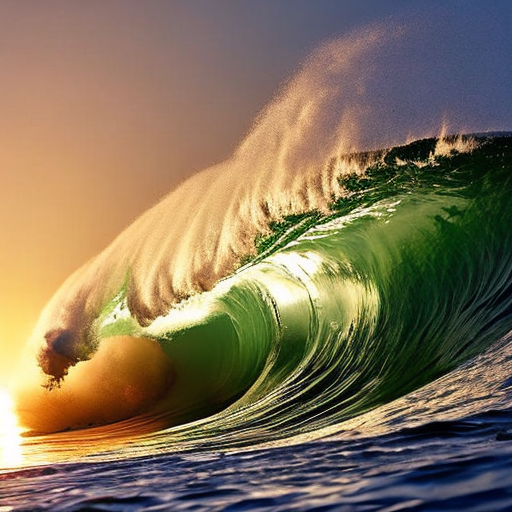

In [4]:
guidance_scale = 8 #@param
num_inference_steps=30 #@param
prompt = "Beautiful picture of a wave breaking" #@param
negative_prompt = "zoomed in, blurry, oversaturated, warped" #@param

# Encode the prompt
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# Create our random starting point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# Loop through the sampling timesteps
for i, t in enumerate(pipe.scheduler.timesteps):

    # expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2)

    # Apply any scaling required by the scheduler
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual with the unet
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# Decode the resulting latents into an image
with torch.no_grad():
    image = pipe.decode_latents(latents.detach())

# View
pipe.numpy_to_pil(image)[0]